In [1]:
from data_processing import *
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from model import *

import matplotlib.pyplot as plt
from IPython.display import clear_output, display


import numpy as np
import os

In [2]:
velocity_path = '../data'
normalized_velocities, image_filenames, normalized_midpoint = combine_and_normalize_velocity_files(velocity_path, log_transform=True)

Minimum velocity: 1.89
Maximum velocity: 39.32
Number of negative velocities: 0
[[ 8.05 12.4 ]
 [ 8.34 12.16]
 [ 8.12 12.07]
 [ 6.88 11.44]
 [ 7.76 11.43]]
[0.64919355 0.68585526 0.67274234 0.6013986  0.67891514]
Minimum rel velocity: 0.1882521489971347
Maximum rel velocity: 2.7437950360288235
Minimum log velocity: -1.6699729967118622
Maximum log velocity: 1.0093420117490313
Minimum normalized velocity: 0.0
Maximum normalized velocity: 1.0
Normalized midpoint: 0.5


In [3]:
print(np.info(normalized_velocities))

class:  ndarray
shape:  (316,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x23a9521d310
byteorder:  little
byteswap:  False
type: float64
None


In [4]:
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize 
])

In [5]:
image_folder_path = '../data'
# Assuming 'normalized_velocities' and 'image_folder_path' are already defined
full_dataset = PathFollowingDataset(image_filenames, normalized_velocities, transform=data_transform)

print(full_dataset.image_filenames[130:135])
# Define the size of the training and validation sets 80/20 train/test split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Randomly split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# print(full_dataset[40:45]['velocity'])
for i in range(130,135):
    data = full_dataset[i]  # Access each dataset item individually
    print(data['velocity']) 
# print(val_dataset[1])


['../data\\image136.jpg', '../data\\image137.jpg', '../data\\image138.jpg', '../data\\image139.jpg', '../data\\image140.jpg']
tensor(0.3971)
tensor(0.4641)
tensor(0.4793)
tensor(0.3139)
tensor(0.3598)


c:\Users\kxfor\OneDrive\Documents\Projects\Autonomous-Driving-Project\path_tracking\data_processing.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'image': torch.tensor(image, dtype=torch.float), 'velocity': torch.tensor(velocity, dtype=torch.float)}


In [6]:

# Define the DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [7]:
model = CNNRegressor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted

In [12]:
def train_and_validate_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=75, patience = 15, min_loss_change=0.005):
    model.train()  # Set the model to training mode initially

    train_losses = []
    val_losses = []
    epochs_no_improve = 0
    last_loss = float('inf')
    last_val_loss = float('inf')

    # Create a figure for plotting
    plt.figure(figsize=(10, 5))
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_losses = []

        # Training Phase
        for i, data in enumerate(train_dataloader, 0):
            inputs = data['image'].to(device)
            targets = data['velocity'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_losses.append(loss.item())

            if i % 10 == 9:    # Print every 10 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        # if epoch != 0:
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()  # Set the model to evaluation mode for validation
        val_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                inputs = data['image'].to(device)
                targets = data['velocity'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Checkpointing
        # defintiely a better way to do this using % but i cant be bothered lol
        if epoch == 24 or epoch == 35 or epoch == 45 or epoch == 55 or epoch == 65:
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
            print(f'Model saved at epoch {epoch+1}')
        
        if avg_train_loss < 0.1 and avg_val_loss < 0.1:
            torch.save(model.state_dict(), f'model_low_loss_epoch_{epoch+1}.pth')
            print(f'Model saved with low loss at epoch {epoch+1}')

        # check convergence
        if abs(avg_train_loss - last_loss) < min_loss_change:
            epochs_no_improve+=1
        else:
            epochs_no_improve=0

        if epochs_no_improve >= patience:
            torch.save(model.state_dict(), f'model_coverged_epoch_{epoch+1}.pth')
            print(f'Model has converged and saved at epoch {epoch+1}')
            break

        last_loss = avg_train_loss

        if avg_val_loss < last_val_loss - min_loss_change:
            epochs_no_improve = 0
            last_val_loss = avg_val_loss
        else:
            epochs_no_improve += 1

        # Plotting
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.yscale('log')  # Set the y-axis to logarithmic scale
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss')
        plt.title('Training and Validation Loss on Log Scale')
        plt.legend()
        
        clear_output(wait=True)
        # display(plt.gcf())
        
        plt.pause(0.001)
        print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}')
        print(" ")
        print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}')


        model.train()  # Reset to training mode for the next epoch

    plt.show()
    print('Finished Training and Validation')


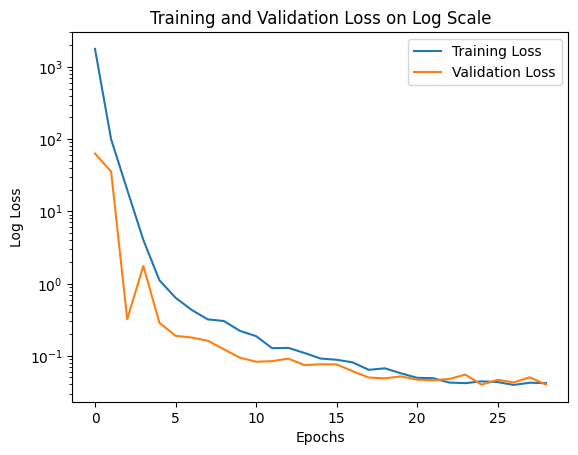

Epoch 29, Validation Loss: 0.0399
 
Epoch 29, Training Loss: 0.0418
Epoch 30, Batch 10, Loss: 0.0444
Model saved with low loss at epoch 30
Model has converged and saved at epoch 30
Finished Training and Validation


In [13]:
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=75)
